In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
image_size = (224, 224)
batch_size = 32

train = tf.keras.preprocessing.image_dataset_from_directory(
    "./Data/data_severity/training/",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val = tf.keras.preprocessing.image_dataset_from_directory(
    "./Data/data_severity/validation/",
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 979 files belonging to 3 classes.
Found 171 files belonging to 3 classes.


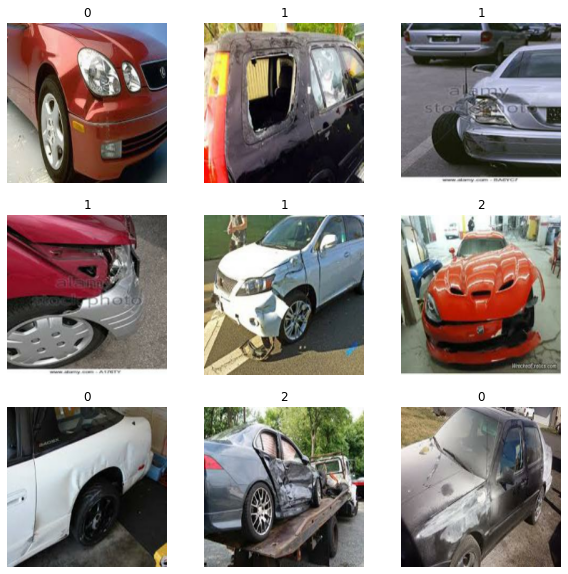

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    labels=np.argmax(labels, axis=1)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
new_input = keras.Input(shape=(224, 224, 3))
base_model = mobilenet.MobileNet(include_top=False, 
                            input_tensor=new_input, 
                            pooling='max', 
                            weights='imagenet')

In [5]:
# freeze base model to use the pre-trained imagenet weights!
base_model.trainable=False

In [6]:
augmented_train = train.map(
  lambda x, y: (mobilenet.preprocess_input(x), y))
augmented_val = val.map(
  lambda x, y: (mobilenet.preprocess_input(x), y))

In [20]:
model=keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dropout(0.9))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_3 (Dense)              (None, 300)               307500    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 903       
Total params: 3,537,267
Trainable params: 3,515,379
Non-trainable params: 21,888
_________________________________________________________________


In [21]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.categorical_crossentropy,
             metrics=[keras.metrics.categorical_accuracy]
             )

In [22]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [23]:
results_freeze = model.fit(augmented_train, 
                    epochs=15, 
                    validation_data=augmented_val,
                    verbose=1,
                    callbacks=[callback],
                    
                   )

Epoch 1/15
31/31 [==============================] - 60s 2s/step - loss: 7.6435 - categorical_accuracy: 0.4893 - val_loss: 4.2223 - val_categorical_accuracy: 0.3216
Epoch 2/15
31/31 [==============================] - 66s 2s/step - loss: 1.2245 - categorical_accuracy: 0.4862 - val_loss: 1.4895 - val_categorical_accuracy: 0.3918
Epoch 3/15
31/31 [==============================] - 66s 2s/step - loss: 0.9683 - categorical_accuracy: 0.5077 - val_loss: 1.6137 - val_categorical_accuracy: 0.3743
Epoch 4/15
31/31 [==============================] - 64s 2s/step - loss: 0.8762 - categorical_accuracy: 0.5475 - val_loss: 1.2293 - val_categorical_accuracy: 0.4386
Epoch 5/15
31/31 [==============================] - 66s 2s/step - loss: 0.9010 - categorical_accuracy: 0.5424 - val_loss: 1.1199 - val_categorical_accuracy: 0.4854
Epoch 6/15
31/31 [==============================] - 67s 2s/step - loss: 0.8640 - categorical_accuracy: 0.5771 - val_loss: 0.9359 - val_categorical_accuracy: 0.5614
Epoch 7/15
31/31

In [24]:
# unfreeze base model!
base_model.trainable=True

In [25]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
             loss=keras.losses.categorical_crossentropy,
             metrics=[keras.metrics.categorical_accuracy]
             )

In [26]:
checkpoint_filepath = './Saved_Models/Model_severity/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
results_unfreeze = model.fit(augmented_train, 
                    epochs=10, 
                    validation_data=augmented_val,
                    verbose=1,
                    callbacks=[callback,model_checkpoint_callback],
                    
                   )

Epoch 1/10
31/31 [==============================] - 66s 2s/step - loss: 0.7854 - categorical_accuracy: 0.6241 - val_loss: 0.8111 - val_categorical_accuracy: 0.6257


INFO:tensorflow:Assets written to: ./Saved_Models/Model_severity/assets


INFO:tensorflow:Assets written to: ./Saved_Models/Model_severity/assets


Epoch 2/10
31/31 [==============================] - 69s 2s/step - loss: 0.7819 - categorical_accuracy: 0.6190 - val_loss: 0.7980 - val_categorical_accuracy: 0.6316


INFO:tensorflow:Assets written to: ./Saved_Models/Model_severity/assets


INFO:tensorflow:Assets written to: ./Saved_Models/Model_severity/assets


Epoch 3/10
31/31 [==============================] - 69s 2s/step - loss: 0.7702 - categorical_accuracy: 0.6496 - val_loss: 0.7919 - val_categorical_accuracy: 0.6316
Epoch 4/10
31/31 [==============================] - 67s 2s/step - loss: 0.7444 - categorical_accuracy: 0.6527 - val_loss: 0.7874 - val_categorical_accuracy: 0.6257
Epoch 5/10
31/31 [==============================] - 66s 2s/step - loss: 0.7364 - categorical_accuracy: 0.6282 - val_loss: 0.7824 - val_categorical_accuracy: 0.6140
Epoch 6/10
31/31 [==============================] - 67s 2s/step - loss: 0.7401 - categorical_accuracy: 0.6527 - val_loss: 0.7853 - val_categorical_accuracy: 0.6082
Epoch 7/10
31/31 [==============================] - 65s 2s/step - loss: 0.7100 - categorical_accuracy: 0.6435 - val_loss: 0.7847 - val_categorical_accuracy: 0.6140
Epoch 8/10
31/31 [==============================] - 67s 2s/step - loss: 0.7068 - categorical_accuracy: 0.6394 - val_loss: 0.7827 - val_categorical_accuracy: 0.6140
Epoch 9/10
31/31

In [28]:
model2 = keras.models.load_model('./Saved_Models/Model_severity')